# Análisis del perfil crediticio de clientes bancarios 


### Carga de Librerías

In [257]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#Importar SMOTE
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from collections import Counter

### 1. Carga del CSV y Presentación Inicial

In [245]:
#Cargar datos del CSV (variable datos)
datos = pd.read_csv('loan_data.csv')

#Mostrar tamaño del datosset
print(datos.shape)

#Mostrar tipos de columnas
datos.info()

#Mostrar describe
print(datos.describe())

#Mostrar primeras filas de cada columna
print(datos.head())

#Guardamos variables target (Valor objetivo primer y segundo modelo)
target = 'loan_status'
target_regresion = 'risk_score'

(45000, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               45000 non-null  float64
 1   gender            45000 non-null  object 
 2   education         45000 non-null  object 
 3   income            45000 non-null  float64
 4   yrs_exp           45000 non-null  int64  
 5   ownership         45000 non-null  object 
 6   amount            45000 non-null  float64
 7   purpose           44962 non-null  object 
 8   int_rate          45000 non-null  float64
 9   percent_income    45000 non-null  float64
 10  cred_hist_length  45000 non-null  float64
 11  risk_score        45000 non-null  int64  
 12  previous_loans    45000 non-null  object 
 13  loan_status       45000 non-null  int64  
dtypes: float64(6), int64(3), object(5)
memory usage: 4.8+ MB
                age        income       yrs_exp        amount    

Tenemos 45000 registros alojados en 14 columnas

Además hemos detectado que hay diferentes errores como:

Edad (age) max , que está en **144 años**

Años de exp (yrs_exp) max que están en **125 años**

El risk_score min **-637.00**

El risk_score max **77000** que desvirtua los datos

Procederemos a limpiarlos:

### 2. Limpieza de Datos
- 2.1 Gestión de Valores Nulos
- 2.2 Detección de Valores Erróneos

In [246]:
#Detección de valores nulos
print(datos.isnull().sum())

#Detección de valores erróneos
#Mostramos los valores unicos de cada columnas categoricas
print("Valores unicos de cada columna categoricas")
for column in datos.select_dtypes(include='object').columns:
    print(column, datos[column].unique())
    


age                  0
gender               0
education            0
income               0
yrs_exp              0
ownership            0
amount               0
purpose             38
int_rate             0
percent_income       0
cred_hist_length     0
risk_score           0
previous_loans       0
loan_status          0
dtype: int64
Valores unicos de cada columna categoricas
gender ['female' 'male' 'femal']
education ['Master' 'High School' 'Bachelor' 'Associate' 'Doctorate']
ownership ['RENT' 'OWN' 'MORTGAGE' 'OTHER' 'OWN ']
purpose ['PERSONAL' 'EDUCATION' 'MEDICAL' 'VENTURE' 'HOMEIMPROVEMENT'
 'DEBTCONSOLIDATION' nan]
previous_loans ['No' 'Yes']


Como vemos, tenemos valores nulos en el **purpose** , además tenemos el **gender** mal con un 'femal' y dos OWN en **ownership**

Procederemos a limpiarlos

### Aplicamos técnicas de limpieza de datos

In [247]:
#Eliminar filar con campos nulos
data_clean = datos.dropna()


#Repetimos la detección de valores nulos
#print(data_clean.isnull().sum())

#Corroboramos que se hayan eliminado los valores nulos
null_values = data_clean.isnull().sum().sort_values(ascending=False)
print("Cantidad de valores nulos por columna")
print(null_values)

#Quitamos registros de femal y los pasamos a female
data_clean = data_clean.replace({'femal': 'female'})
#Quitamos un OWN
data_clean = data_clean.replace({'OWN ': 'OWN'})

#Volvemos a comprobar los valores únicos
for column in data_clean.select_dtypes(include='object').columns:
    print(column, data_clean[column].unique())

Cantidad de valores nulos por columna
age                 0
gender              0
education           0
income              0
yrs_exp             0
ownership           0
amount              0
purpose             0
int_rate            0
percent_income      0
cred_hist_length    0
risk_score          0
previous_loans      0
loan_status         0
dtype: int64
gender ['female' 'male']
education ['Master' 'High School' 'Bachelor' 'Associate' 'Doctorate']
ownership ['RENT' 'OWN' 'MORTGAGE' 'OTHER']
purpose ['PERSONAL' 'EDUCATION' 'MEDICAL' 'VENTURE' 'HOMEIMPROVEMENT'
 'DEBTCONSOLIDATION']
previous_loans ['No' 'Yes']


Como vemos, ahora sí está limpio

### Detección de Valores Atípicos

Ahora comprobaremos las columnas con valores numéricos para detectar posibles valores atípicos. Usaremos un gráfico de cajas Box Plot para representarlos

Index(['age', 'income', 'yrs_exp', 'amount', 'int_rate', 'percent_income',
       'cred_hist_length', 'risk_score', 'loan_status'],
      dtype='object')


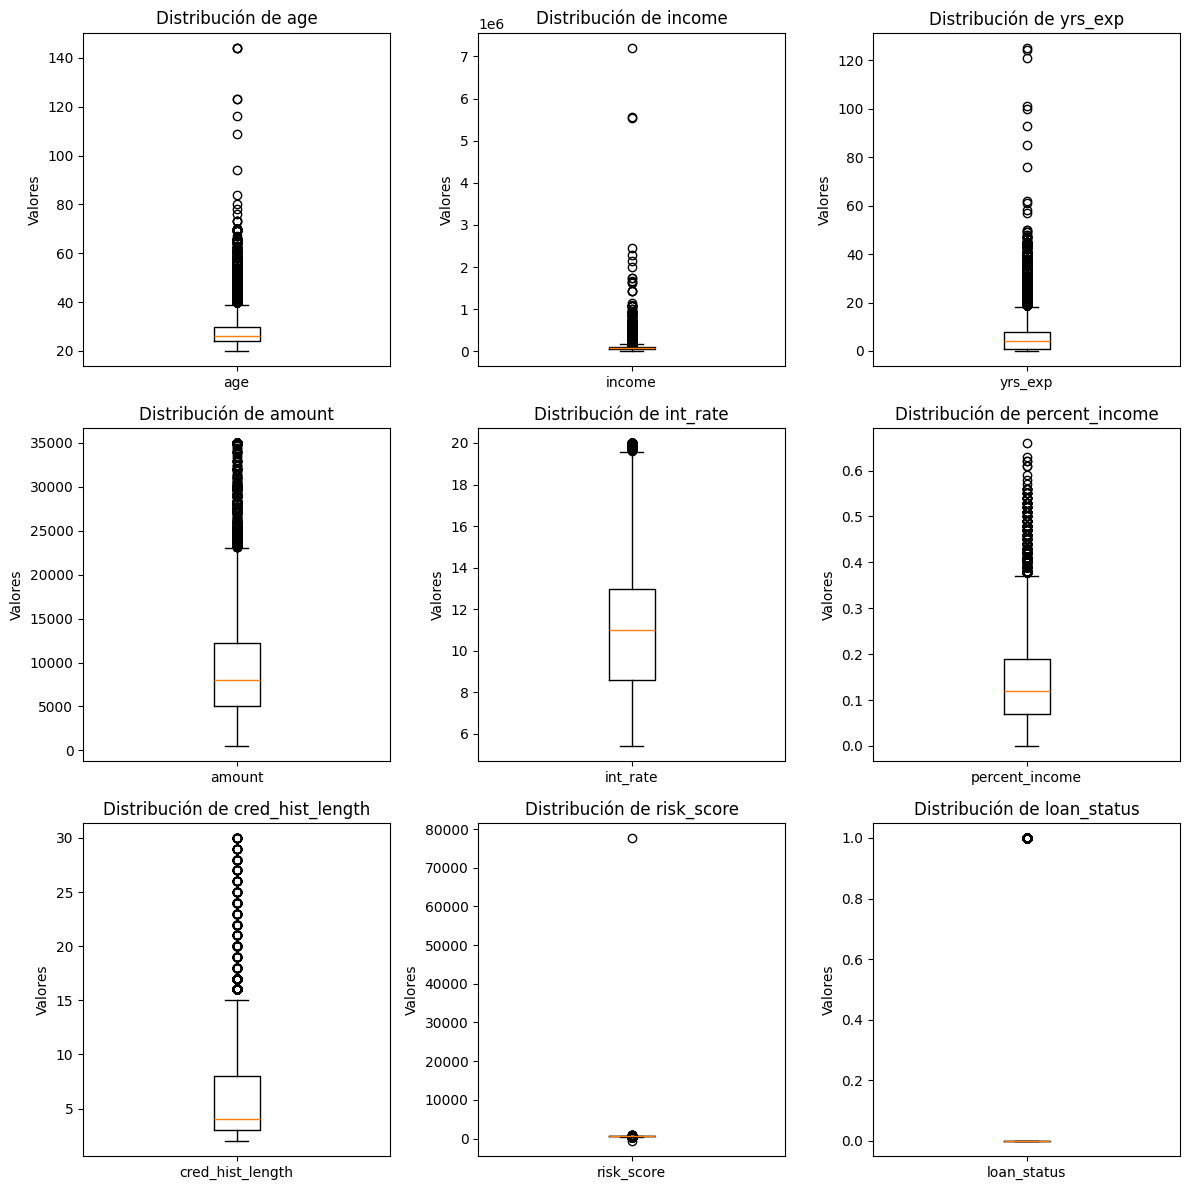

In [248]:
#Solo las numéricas (box plot solo puede representar columnas numéricas)
categorias = data_clean.select_dtypes(include='number').columns
print(categorias)

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12,12)) #Primer 12 largo, segundo ancho

axes = axes.flatten()
for i, var in enumerate(categorias):
    axes[i].boxplot(datos[var], tick_labels=[var])
    axes[i].set_title(f'Distribución de {var}')
    axes[i].set_ylabel('Valores')
    
for j, in range(len(categorias), len(axes)):
    axes[j].axis('off')
    
plt.tight_layout()
plt.show()

Si observamos podemos ver los siguientes valores atípicos:

- age (edad) -> Valores atípicos en 140 que no tienen sentido

- yrs_exp (años exp) -> Valores atípicos en 120 que no tienen sentido

- risk_score (riesgo) -> Un valor atípico en 80000 que se aleja mucho de los demás


Teniendo esto vamos a ajustar los valores de dichas columnas

En el caso de **yrs_exp** la ajustaremos a valores entre 0 y 45 (en España se cotizan 38 años para el 100 % de la jubilación pero añadiremos algunos años más) El resto no lo queremos

En **age** ajustaremos los valores entre 0 y 120 años ya que más no es real

Y el **risk_score** eliminaremos los valores atípicos que se alejan tanto para no alterarnos los resultados posteriores

In [249]:
data_clean['risk_score'].max()

np.int64(77710)

In [254]:
#Calculamos porcentaje de valores atípicos en las columnas age y yrs_exp
total_rows = data_clean.shape[0]

#IDENTIFICACIÓN DE OUTLIERS EN EL RISK_SCORE
#Obtenemos valores atípicos del risk_score
media_risk_score = data_clean['risk_score'].mean()
#Calculamos la desviación estandar
std_risk_score = data_clean['risk_score'].std()
#Aquí almacenaremos los outliers (valores atípicos)
outliers = []

#Cálculo del valor z (z-score mide cuantas desviaciones están alejadas de la media)
for element in data_clean['risk_score'].values:
    z = abs(element - media_risk_score) / std_risk_score
    if z > 2:
        outliers.append(element)
        
#Cálculo del porcentaje de valores atípicos
#Calculamos el porcentaje de valores atipicos en las columnas age, yrs_exp y risk_score
total_outliers = (data_clean[data_clean['age'] > 100].shape[0] + data_clean[data_clean['yrs_exp'] > 51].shape[0] + len(outliers)) * 100 / total_rows
print("El total de valores atipicos es: ", round(total_outliers,4), "%")
print("Cantidad de datos antes de la limpieza: ", data_clean.shape)

#Eliminamos valores atípicos de age y yrs_exp
data_clean = data_clean[data_clean['age'] <= 120]
data_clean = data_clean[data_clean['yrs_exp'] <= 45]

#Eliminamos valores atípicos de risk_score con z-score (la ~ invierte los valores)
data_clean = data_clean[~data_clean['risk_score'].isin(outliers)] #filtra excluyendo los outliers

#Imprimimos resultados para comprobar que ya no estén los valores atípicos
print("El total de valores atipicos es: ", round(total_outliers,4), "%")
print("Cantidad de datos después de la limpieza: ", data_clean.shape)



#Mostrar describe
print(data_clean.describe())



El total de valores atipicos es:  2.1417 %
Cantidad de datos antes de la limpieza:  (40249, 14)
El total de valores atipicos es:  2.1417 %
Cantidad de datos después de la limpieza:  (39387, 14)
                age        income       yrs_exp        amount      int_rate  \
count  39387.000000  3.938700e+04  39387.000000  39387.000000  39387.000000   
mean      27.742834  7.998931e+04      5.388098   9586.063346     11.008747   
std        5.769019  6.268681e+04      5.781116   6318.987776      2.984103   
min       20.000000  8.000000e+03      0.000000    500.000000      5.420000   
25%       24.000000  4.728850e+04      1.000000   5000.000000      8.590000   
50%       26.000000  6.709600e+04      4.000000   8000.000000     11.010000   
75%       30.000000  9.576550e+04      8.000000  12250.000000     12.995000   
max       69.000000  2.448661e+06     45.000000  35000.000000     20.000000   

       percent_income  cred_hist_length    risk_score   loan_status  
count    39387.000000   

Podemos observar que los valores atípicos se han solucionado por lo que pasaremos al siguiente paso

#### Para Recordar
Antes de continuar es buena práctica verificar que el dataset esté balanceado

In [255]:
class_types = data_clean[target].value_counts()
class_proportion = data_clean[target].value_counts(normalize=True) * 100

print("Tipos de clases")
print(class_types)
print("Proporcion de clases")
print(round(class_proportion,2))

Tipos de clases
loan_status
0    30674
1     8713
Name: count, dtype: int64
Proporcion de clases
loan_status
0    77.88
1    22.12
Name: proportion, dtype: float64


El dataset muestra que está desbalanceado ya que para estar balanceado los datos deberían estar en torno a un 40-60 % o 50-50 %

En pasos posteriores aplicaremos alguna técnica para solucionarlo


### 3- Ingeniería de Características

En este proceso vamos a codificar las variables categóricas (no numéricas) para darles un valor numérico

(ejemplo: si es género hombre y mujer pasarlo a 0 y 1)

#### Codificación de variables categóricas
Empezaremos mostrando las columnas para saber las que tenemos que codificar

In [259]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39387 entries, 2 to 44999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               39387 non-null  float64
 1   gender            39387 non-null  object 
 2   education         39387 non-null  object 
 3   income            39387 non-null  float64
 4   yrs_exp           39387 non-null  int64  
 5   ownership         39387 non-null  object 
 6   amount            39387 non-null  float64
 7   purpose           39387 non-null  object 
 8   int_rate          39387 non-null  float64
 9   percent_income    39387 non-null  float64
 10  cred_hist_length  39387 non-null  float64
 11  risk_score        39387 non-null  int64  
 12  previous_loans    39387 non-null  object 
 13  loan_status       39387 non-null  int64  
dtypes: float64(6), int64(3), object(5)
memory usage: 4.5+ MB


In [260]:
#USAMOS MAP PARA LAS COLUMNAS BINARIAS
#USAMOS 
#Aplicamos int a la columna age para garantizar que sea númerica
data_clean['age'] = data_clean['age'].astype(int)

#Convertimos todas las columnas object a category
gender_map = {'male': 0, 'female': 1} #Añadimos valores del 0 y 1
data_clean['gender_encoded'] = data_clean['gender'].map(gender_map)
data_clean.drop(['gender'], axis=1)

#Añadimos a education sus 4 valores
education_map = {'High Schoool': 0, 'Associte': 1, 'Bachelor': 2, 'Master': 3, 'Doctorate': 4}
data_clean['education_encoded'] = data_clean['education'].map(education_map)

#Aplicamos int para garantizar que sea numérica
data_clean['education_encoded'] = data_clean['education_encoded'].fillna(0) #Quita NaN
data_clean['education_encoded'] = data_clean['education_encoded'].astype(int)
data_clean.drop(['education'], axis=1) #1 quiere decir que elimina una columna, no fila

data_ownership = pd.get_dummies(data_clean['ownership'], prefix='ownership', dtype=int, drop_first=True)
data_clean = pd.concat([data_clean, data_ownership], axis=1)

data_purpose = pd.get_dummies(data_clean['purpose'], prefix='purpose', dtype=int, drop_first=True)
data_clean = pd.concat([data_clean, data_purpose], axis=1)

data_previous_loans = {'No': 0, 'Yes': 1}
data_clean['previous_loans_encoded'] = data_clean['previous_loans'].map(data_previous_loans)
data_clean['previous_loans_encoded'] = data_clean['previous_loans_encoded'].astype(int)

data_encoded = data_clean.drop(['gender','education','ownership', 'purpose', 'previous_loans'], axis=1)

data_encoded.info()
data_encoded.head()




<class 'pandas.core.frame.DataFrame'>
Index: 39387 entries, 2 to 44999
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      39387 non-null  int64  
 1   income                   39387 non-null  float64
 2   yrs_exp                  39387 non-null  int64  
 3   amount                   39387 non-null  float64
 4   int_rate                 39387 non-null  float64
 5   percent_income           39387 non-null  float64
 6   cred_hist_length         39387 non-null  float64
 7   risk_score               39387 non-null  int64  
 8   loan_status              39387 non-null  int64  
 9   gender_encoded           39387 non-null  int64  
 10  education_encoded        39387 non-null  int64  
 11  ownership_OTHER          39387 non-null  int64  
 12  ownership_OWN            39387 non-null  int64  
 13  ownership_RENT           39387 non-null  int64  
 14  purpose_EDUCATION        39

,age,income,yrs_exp,amount,int_rate,percent_income,cred_hist_length,risk_score,loan_status,gender_encoded,education_encoded,ownership_OTHER,ownership_OWN,ownership_RENT,purpose_EDUCATION,purpose_HOMEIMPROVEMENT,purpose_MEDICAL,purpose_PERSONAL,purpose_VENTURE,previous_loans_encoded
2,25,12438.0,3,5500.0,12.87,0.44,3.0,635,1,1,0,0,0,0,0,0,1,0,0,0
3,23,79753.0,0,35000.0,15.23,0.44,2.0,675,1,1,2,0,0,1,0,0,1,0,0,0
4,24,66135.0,1,35000.0,14.27,0.53,4.0,586,1,0,3,0,0,1,0,0,1,0,0,0
6,26,93471.0,1,35000.0,12.42,0.37,3.0,701,1,1,2,0,0,1,1,0,0,0,0,0
7,24,95550.0,5,35000.0,11.11,0.37,4.0,585,1,1,0,0,0,1,0,0,1,0,0,0


#### Selección de Características

Vamos a seleccionar las columnas más relevantes con el valor target

Para saber cuales son usaremos un mapa de calor (Mapa de calor de correlación)

Este mapa nos mostrará de forma gráfica las correlaciones entre las columnas y según la correlación sea más cercana al 1 mejor tanto positiva como en negativo

- Valores cercanos a -1 o a 1 indican una fuerte correlación con la **target**

- Valores cercanos a 0 indican poca o ninguna correlación con la **target**

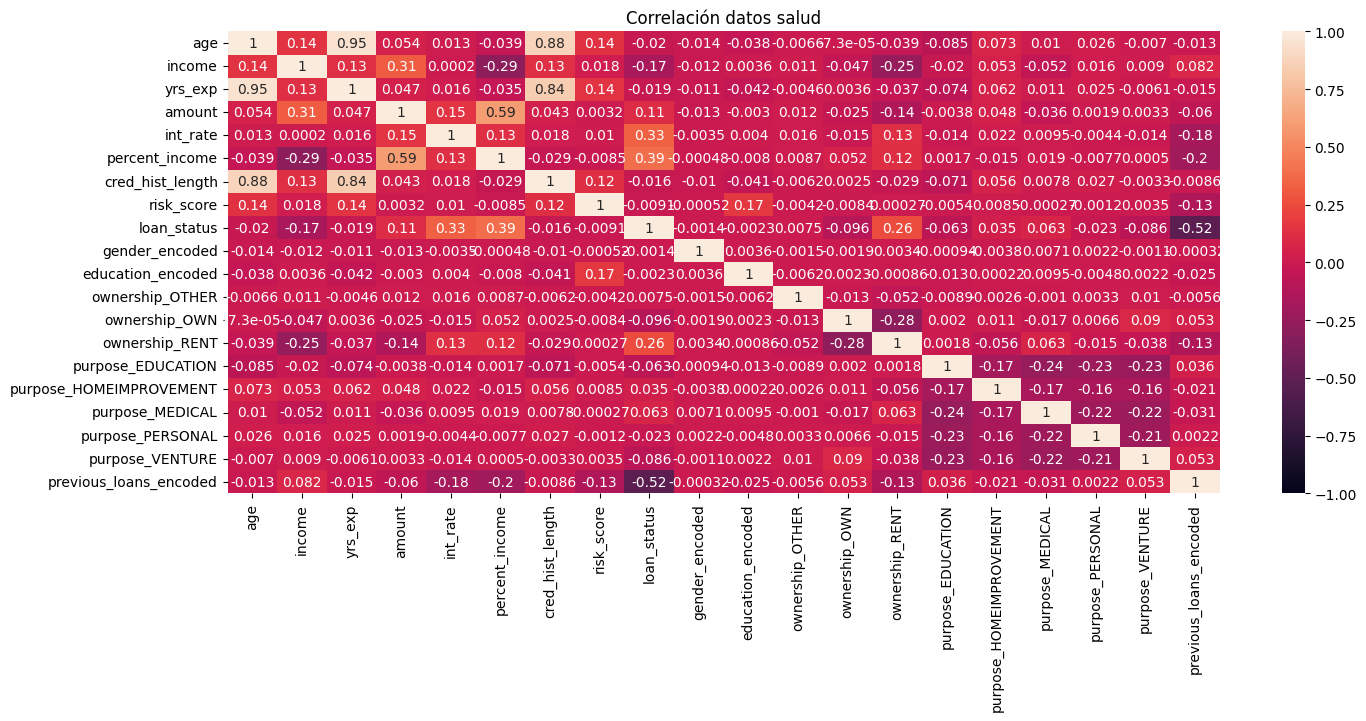

In [262]:
plt.figure(figsize=(16, 6)) 
heatmap = sns.heatmap(data_encoded.corr(), vmin=-1, vmax=1, annot=True) 
heatmap.set_title('Correlación datos salud') 
plt.show()



Como este desbalanceo podría influir en el rendimiento del modelo (más en clasificación) vamos a aplicar la técnica SMOTE. También podríamos hacer sobremuestreo (oversampling) con la clase minoritaria o submuestreo (undersampling) con la clase mayoritaria

#### 📓 Técnica SMOTE para Desbalanceo 



In [ ]:
#Separar características (X) de variable objetivo (y)
X = data_clean.drop('loan_status', axis=1) #Reemplaza loan_status con tu columna objetivo
y = data_clean['loan_status']

#Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Aplicar SMOTE en los datos de entrenamiento
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

#Verificar que se ha balanceado
print("Distribución original: ", Counter(y_train))
print("Distribución con SMOTE: ", Counter(y_train_smote))